# Part II - Ford GoBike System Data
## by Remi Dongmo

## Investigation Overview

In this investigation, I wanted to look at the characteristics of bike sharing data that could be used to determine if a user is subscriber or not. The main support features used were duration, time of day, day of week and age.

## Dataset Overview

The data consisted of 183,412 records of trip information charactarized by 16 features. Some important attributes included duration in second, gps coordinates, gender, start/end dates and birth date, . We converted durations to minute unit, we engineered distance covered from gps coordinates, we dropped records with outlier data and we did some data type conversions. At the end we got an appropriate bank of information to work with.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [3]:
# Replacing birth years with ages

year_of_records = 2019  # The data in the dataset is from 2019
df['age'] = year_of_records - df.member_birth_year
df.drop(columns=['member_birth_year'], inplace=True)

In [4]:
''' Adding some useful additional variables'''

df['time_of_day'] = pd.DatetimeIndex(df.start_time).hour # Time of the day added
df['week_day'] = pd.DatetimeIndex(df.start_time).day_name(locale='English') # Day of the week added

df.loc[df.time_of_day == 0, 'time_of_day'] = 24 # Replacing 0hrs (midnight) with 24hrs

In [5]:
''' Giving variables more appropriate datatypes '''

# Converting timestamps to datetime type
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)

# Converting some important columns to categorical datatype
df.member_gender = df.member_gender.astype('category')
df.bike_share_for_all_trip = df.bike_share_for_all_trip.astype('category')
df.user_type = df.user_type.astype('category')

# Converting id columns to Sttring instead of float or int
df.bike_id = df.bike_id.astype('str')
df.start_station_id = df.start_station_id.astype('str')
df.end_station_id = df.end_station_id.astype('str')

# Converting newly created float ages to int
df.age = df.age.dropna().apply(np.int64)

In [6]:
# Converting durations in minutes

df['duration_min'] = (df.duration_sec/60).astype(np.int64)
df.drop(columns=['duration_sec'], inplace=True)

In [7]:
#Dropping rows missing both age and gender
df = df[df.age.notna()]

In [8]:
# Dropping ages bigger than 60
df = df[df.age <= 60]

In [9]:
''' Replacing GPS Coords between stations with distance (Got help from stack overflow) '''

import math

#Function to compute the distance
def get_distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    return round(d*1000)

        
df['distance_in_meter'] = df.apply(lambda i: get_distance((i['start_station_latitude'], i['start_station_longitude']),(i['end_station_latitude'], i['end_station_longitude'])), axis=1)


df.drop(columns=['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude'], inplace=True)

In [10]:
# Declaring some useful constants

color = sb.color_palette()[0]
isMale = df.member_gender == 'Male'
isFemale = df.member_gender == 'Female'
isOther = df.member_gender == 'Other'
isSubscriber = df.user_type == 'Subscriber'
isCustomer = df.user_type == 'Customer'

## Distribution of time of the day acording to both user types

The user type has no influence on the hourly traffic. For both customers and subscribers, most of the trips are carried out during the morning and at the end of the day. We could be tempted to deduce that many users use the bicycles to get to their 9-5 jobs or schools.

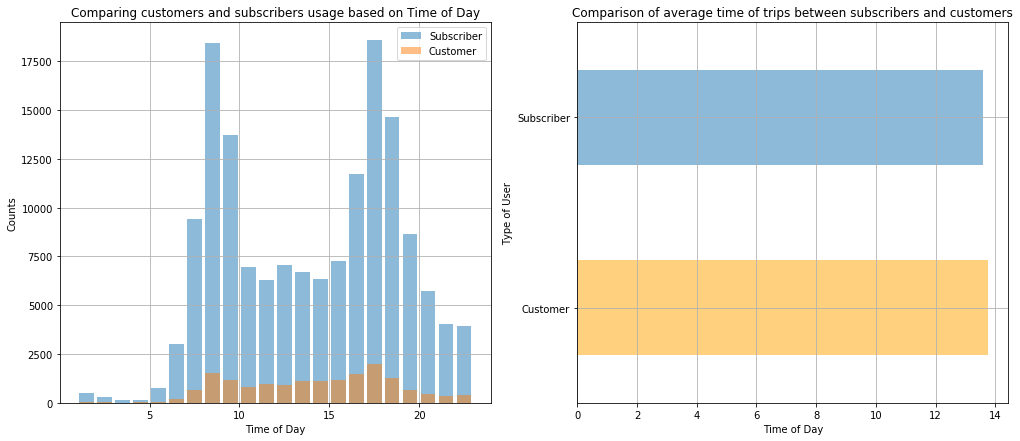

In [11]:
plt.figure(figsize=(17,7))
time_bins = np.arange(1, 24, 1)
plt.subplot(1,2,1)
df.time_of_day[isSubscriber].hist(alpha=0.5, bins=time_bins, rwidth=0.8, label='Subscriber')
df.time_of_day[isCustomer].hist(alpha=0.5, bins=time_bins, rwidth=0.8, label='Customer')
plt.title('Comparing customers and subscribers usage based on Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Counts')
plt.legend();

plt.subplot(1,2,2)
df.groupby('user_type')['time_of_day'].mean().plot(kind='barh', alpha=0.5, color=['orange', color])
plt.title('Comparison of average time of trips between subscribers and customers')
plt.ylabel('Type of User')
plt.xlabel('Time of Day')
plt.grid();

## Distribution of trip duration according to both user types

The trip duration has a quite noticeable dependence on the user type. Subscribed users ride less than half the time customers do. While customers complete their trips in **21 minutes** on average, subscribers only need **10 minutes** usually. This could be explained by the fact that paying a ride at a time and at a higher price encourages customers to enjoy their trip more longer. According to <a href="https://divvybikes.com/pricing">this</a> bike sharing company pricing, single rides of 30 minutes cost **$1** while subscribers can have unlimited 45 minutes rides for only **$10/month**

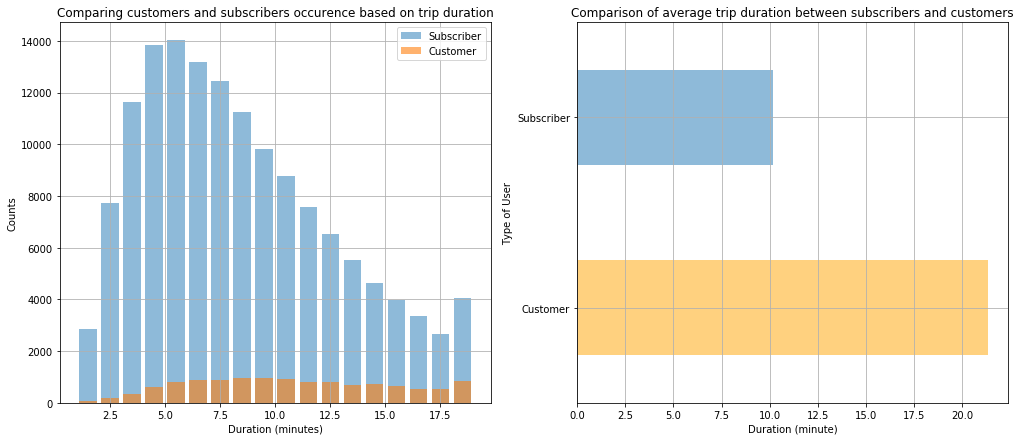

In [12]:
plt.figure(figsize=(17,7))

duration_bins = np.arange(df.duration_min.min(), 20, 1)
plt.subplot(1, 2, 1)
df.duration_min[isSubscriber].hist(alpha=0.5, bins=duration_bins, label='Subscriber', rwidth=0.8)
df.duration_min[isCustomer].hist(alpha=0.6, bins=duration_bins, label='Customer', rwidth=0.8)
plt.title('Comparing customers and subscribers occurence based on trip duration')
plt.xlabel('Duration (minutes)')
plt.ylabel('Counts')
plt.legend();

plt.subplot(1, 2, 2)
df.groupby('user_type')['duration_min'].mean().plot(kind='barh', alpha=0.5, color=['orange', color])
plt.title('Comparison of average trip duration between subscribers and customers')
plt.ylabel('Type of User')
plt.xlabel('Duration (minute)')
plt.grid()

## Duration and traffic of trips per week day according to both user types

Customers and Subscribers differ a lot on how they use the bike services throughout the week. Subscribers use the service a lot more during business days (monday to friday) as compared to weekends, they complete the trips in consistent amounts of times too (**10 minutes** during business days). On the other side, customers traffic is kinda stable throughout the whole week  (Monday to Sunday). However, one thing they clearly have in common is that their trips take more time during weekends, this is a lot more noticeable for customers: they ride approximatively for **27 minutes** during weekends while the overall average riding time is **11 minutes**. We were suspecting earlier that subscribers were using the bikes as means of transportation for their jobs, these observations just reinforces that theory.  


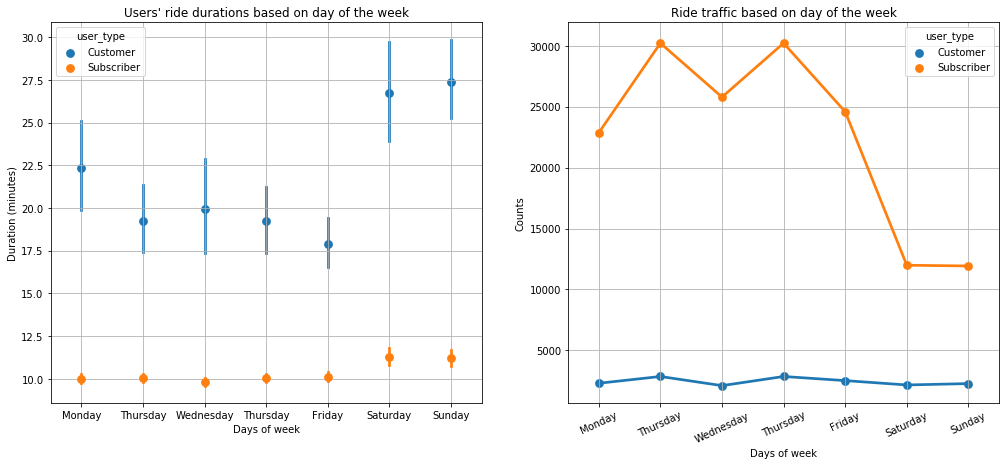

In [13]:
plt.figure(figsize=(17,7))

weeks = ['Monday','Thursday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.subplot(1, 2, 1)
sb.pointplot(data=df, x='week_day', y='duration_min', hue='user_type', linestyles='', order=weeks)
plt.title('Users\' ride durations based on day of the week')
plt.xlabel('Days of week')
plt.ylabel('Duration (minutes)')
plt.grid()

plt.subplot(1, 2, 2)
sb.pointplot(data=df.groupby(['week_day', 'user_type']).size().reset_index(), x='week_day', y=0, hue='user_type', order=weeks)
plt.title('Ride traffic based on day of the week')
plt.xlabel('Days of week')
plt.ylabel('Counts')
plt.xticks(rotation=25)
plt.grid()

## Age by gender according to wether or not rides are all trip bike shares

Whatever their gender, users are less open to do all trip bike shares as they get older. However, this is surprisingly more visible for males.  Obviously, doing all trip bike shares is very dependent on both the gender and the age of users.

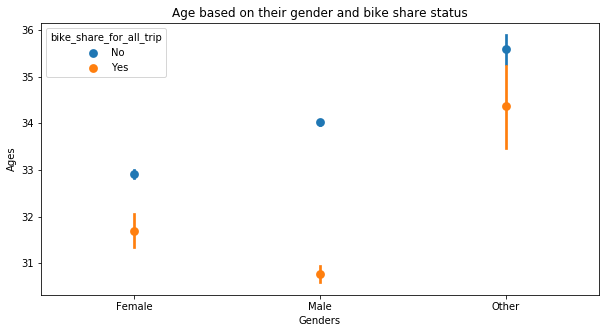

In [14]:
plt.figure(figsize=(10,5))
sb.pointplot(data=df, x='member_gender', y='age', hue='bike_share_for_all_trip', linestyles='')
plt.title('Age based on their gender and bike share status')
plt.xlabel('Genders')
plt.ylabel('Ages')
plt.show()

### Generate Slideshow
Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show.  

In [15]:
# Use this command if you are running this file in local
!jupyter nbconvert FordGoBike_Data_Part2_Slides.ipynb --to slides --post serve --no-input --no-prompt